In [1]:
# import time libraries
import time
from datetime import datetime
from time import gmtime, strftime

# Set Begin Time to Measure Time to Run of Whole Notebook
begin_time = time.time()

In [2]:
## Pull Relavent Libraries

# Standard Libraries
import pandas as pd
import numpy as np
import os
import math
import requests
from io import StringIO
#from StringIO import StringIO
import sys
import os.path
from IPython.display import display, HTML

# For Visualizations
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Other
import scipy
from scipy.stats import norm, skew #for some statistics
from scipy.special import boxcox1p
from datetime import timedelta

# Import Functions Built
from Functions import countplotshorizontal, null_values, histogram, stacked_bar, anova, spearman_df, spearman_chart, encode, QQ

# Set Notebook Options
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x))
bold = "\033[1m"
reset = "\033[0;0m"

In [3]:
# Read Back in the DataFrame
os.chdir(sys.path[0] + '\\Data')
# os.chdir('C:\\Users\\apost\\Desktop\\Python\\CL\\LendingClub\\Data')

df = pd.read_pickle('df2.pkl')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 429387 entries, 0 to 421094
Columns: 113 entries, id to debt_settlement_flag_E
dtypes: category(3), datetime64[ns](6), float64(36), int32(48), int64(5), object(15)
memory usage: 286.2+ MB


In [4]:
df[['YearMonth']].info()
df['OOT_Ind'] = np.where(df['YearMonth'] >= '201501', 1, 0)

display(HTML(df[0:5].to_html()))
display(HTML(df.tail().to_html()))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 429387 entries, 0 to 421094
Data columns (total 1 columns):
YearMonth    429387 non-null object
dtypes: object(1)
memory usage: 6.6+ MB


,id,loan_amnt,funded_amnt,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,purpose,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag,count,YearMonth,YearQtr,fico_avg,fico_bin,GCL,NCL,replacement_d,time_in_file,term_int,loan_end_date,life_of_loan,life_of_loan_years,servicing_fee,total_rev,annual_rev,roa,term_E,grade_E,sub_grade_E,home_ownership_E,verification_status_E,purpose_E,addr_state_E,initial_list_status_E,debt_settlement_flag_E,OOT_Ind
0,10149566,8000,8000.000,36 months,10.990,261.880,B,B2,2,MORTGAGE,33000,Not Verified,2013-12-01,Charged Off,n,debt_consolidation,800xx,CO,15.750,0,1991-07-01,685,689,1,9,1,7203.000,34.600,16,f,5622.500,5622.500,3854.810,1120.220,15.000,632.470,113.720,2015-10-01,276.880,2016-10-01,524,520,0,1,Individual,0,0,15949,20800,2,1772,2255,72.500,0,0,129,269,14,14,0,18,6,0,3,5,4,7,2,8,14,5,9,0,0,0,0,100.000,75.000,1,0,33226,15949,8200,12426,N,Cash,N,1,201312,201304,687.000,682 to 697,-2362.500,-2881.250,2013-12-31,269.043,36,2016-11-30,21.979,1.832,56.225,-2547.445,-1390.814,-17.385,2.000,5.000,35.000,4.000,3.000,5.000,45.000,2.000,2.000,0
1,10148122,12000,12000.000,36 months,7.620,373.940,A,A3,3,MORTGAGE,96500,Not Verified,2013-12-01,Fully Paid,n,debt_consolidation,782xx,TX,12.610,0,2003-09-01,705,709,0,17,0,13248.000,55.700,30,f,13397.540,13397.540,12000.000,1397.540,0.000,0.000,0.000,2016-06-01,2927.220,2018-12-01,819,815,0,1,Individual,0,0,200314,23800,4,11783,2441,83.500,0,0,123,118,10,9,1,10,10,0,4,5,4,10,15,8,14,5,17,0,0,0,3,100.000,100.000,0,0,233004,46738,14800,53404,N,Cash,N,1,201312,201304,707.000,698 to 717,1397.540,1397.540,2013-12-31,123.006,36,2016-11-30,29.996,2.500,133.975,1263.565,505.495,4.212,2.000,4.000,33.000,4.000,3.000,5.000,32.000,2.000,2.000,0
2,10129506,20800,20800.000,36 months,13.530,706.160,B,B5,10,RENT,81500,Verified,2013-12-01,Fully Paid,n,debt_consolidation,100xx,NY,16.730,0,1998-06-01,685,689,2,29,0,23473.000,54.500,41,f,23926.640,23926.640,20800.000,3126.640,0.000,0.000,0.000,2015-05-01,13334.930,2018-12-01,654,650,0,1,Individual,0,0,23473,43100,9,869,6811,54.600,0,0,115,186,0,0,0,0,0,1,8,24,11,17,1,29,40,24,29,0,0,0,3,90.200,50.000,0,0,43100,23473,15000,0,N,Cash,N,1,201312,201304,687.000,682 to 697,3126.640,3126.640,2013-12-31,186.021,36,2016-11-30,16.953,1.413,239.266,2887.374,2043.824,9.826,2.000,5.000,26.000,1.000,2.000,5.000,9.000,2.000,2.000,0
3,10159611,10000,10000.000,36 months,9.670,321.130,B,B1,7,MORTGAGE,102000,Not Verified,2013-12-01,Fully Paid,n,debt_consolidation,027xx,MA,15.550,2,1989-10-01,670,674,0,9,0,9912.000,44.400,22,f,11560.462,11560.460,10000.000,1560.460,0.000,0.000,0.000,2017-01-01,320.910,2018-11-01,659,655,0,1,Individual,0,0,39143,22300,3,4349,973,89.400,0,0,243,290,23,8,0,25,8,1,3,4,3,6,9,6,13,4,9,0,0,0,1,77.300,66.700,0,0,58486,39143,9200,36186,N,Cash,N,1,201312,201304,672.000,<= 681,1560.462,1560.462,2013-12-31,290.004

,id,loan_amnt,funded_amnt,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,purpose,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag,count,YearMonth,YearQtr,fico_avg,fico_bin,GCL,NCL,replacement_d,time_in_file,term_int,loan_end_date,life_of_loan,life_of_loan_years,servicing_fee,total_rev,annual_rev,roa,term_E,grade_E,sub_grade_E,home_ownership_E,verification_status_E,purpose_E,addr_state_E,initial_list_status_E,debt_settlement_flag_E,OOT_Ind
421090,36371250,10000,10000.000,36 months,11.990,332.100,B,B5,8,RENT,31000,Verified,2015-01-01,Fully Paid,n,debt_consolidation,905xx,CA,28.690,0,2004-09-01,670,674,0,9,1,14037.000,82.100,15,f,11947.244,11947.240,10000.000,1947.240,0.000,0.000,0.000,2018-01-01,331.900,2018-01-01,699,695,0,1,Individual,0,0,25274,17100,2,3159,448,95.100,0,0,122,115,17,10,0,90,9,0,3,6,3,4,7,7,8,6,9,0,0,0,1,100.000,100.000,0,0,32950,25274,9200,15850,N,Cash,N,1,201501,201501,672.000,<= 681,1947.244,1947.244,2015-01-31,123.992,36,2017-12-31,36.008,3.001,119.472,1827.772,609.118,6.091,2.000,5.000,26.000,1.000,2.000,5.000,28.000,2.000,2.000,1
421091,36441262,24000,24000.000,36 months,11.990,797.030,B,B5,10,MORTGAGE,79000,Verified,2015-01-01,Fully Paid,n,home_improvement,072xx,NJ,3.900,0,1974-03-01,660,664,1,5,0,8621.000,84.500,23,f,28663.687,28663.690,24000.000,4663.690,0.000,0.000,0.000,2018-02-01,2.580,2018-01-01,699,695,0,1,Individual,0,0,140285,10200,3,35071,976,89.200,0,0,0,488,3,3,4,3,3,10,2,3,3,14,0,4,17,3,5,0,0,0,2,56.500,100.000,0,0,152650,8621,9000,0,N,Cash,N,1,201501,201501,662.000,<= 681,4663.687,4663.687,2015-01-31,490.053,36,2017-12-31,37.027,3.086,286.637,4377.050,1418.560,5.911,2.000,5.000,26.000,4.000,2.000,10.000,19.000,2.000,2.000,1
421092,36271333,13000,13000.000,60 months,15.990,316.070,D,D2,5,RENT,35000,Verified,2015-01-01,Charged Off,n,debt_consolidation,378xx,TN,30.900,0,2003-09-01,680,684,0,9,1,11031.000,61.300,22,w,6109.520,6109.520,2527.700,2506.320,0.000,1075.500,193.590,2016-05-01,316.070,2016-12-01,569,565,0,1,Individual,0,0,34178,18000,7,3798,2554,75.900,0,0,134,108,6,6,0,17,10,0,4,6,4,4,12,7,10,6,9,0,0,0,3,100.000,50.000,1,0,51239,34178,10600,33239,N,Cash,N,1,201501,201501,682.000,682 to 697,-6890.480,-7772.390,2015-01-31,136.016,60,2020-01-01,15.967,1.331,61.095,-7145.165,-5369.900,-41.307,1.000,2.000,18.000,1.000,2.000,5.000,7.000,1.000,2.000,1
421093,36490806,12000,12000.000,60 months,19.990,317.860,E,E3,1,RENT,64400,Source Verified,2015-01-01,Charged Off,n,debt_consolidation,010xx,MA,27.190,1,2003-10-01,695,699,2,17,0,8254.000,30.600,20,w,5366.990,5366.990,1552.690,2234.980,0.000,1579.320,284.278,2016-01-01,317.860,2016-10-01,499,0,1,1,Individual,0,0,58418,27000,6,3895,3752,61.300,0,0,56,83,5,5,0,12,0,1,5,7,7,7,3,15,16,7,17,0,0,1,2,95.000,66.700,0,0,96919,58418,9700,69919,N,Cash,N,1,201501,201501,697.000,682 to 697,-6633.010,-7928.052,2015-01-31,135.031,60,2020-01

## Begin Categorical Transformations
### Let's Collapse The Category Names with < 5% of Volume and Rename to "Other"
* Set a Lower Threshold for "Neighborhood" Since it Contains Many Small Categories

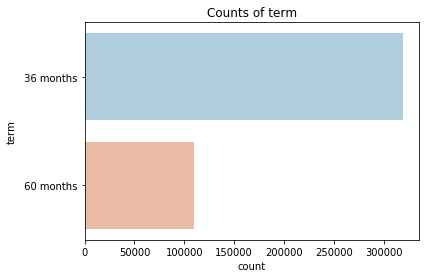

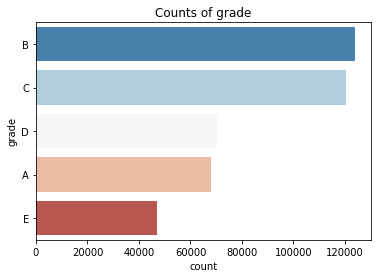

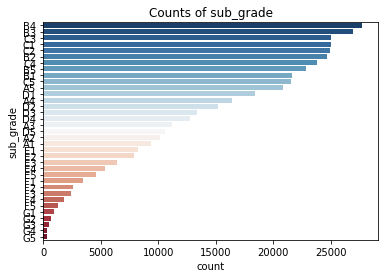

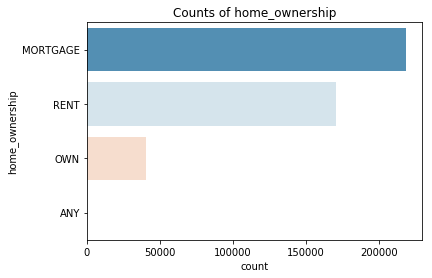

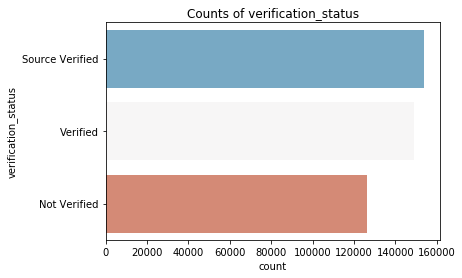

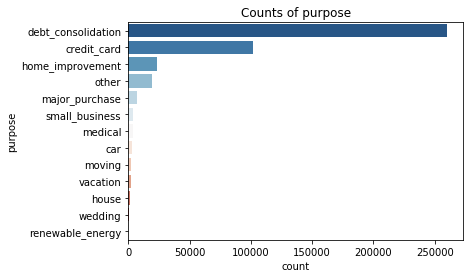

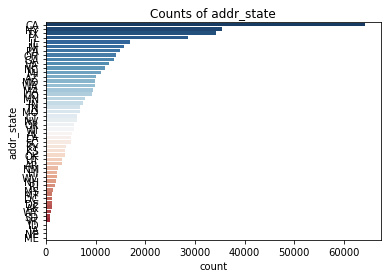

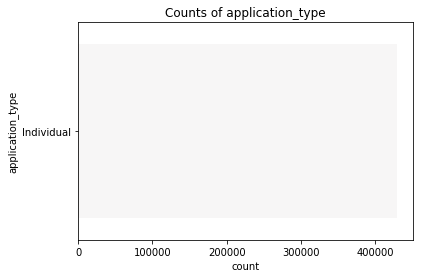

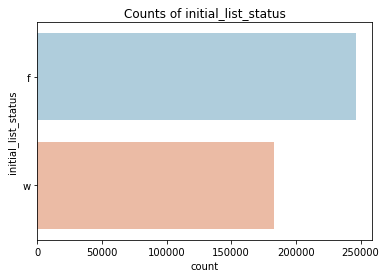

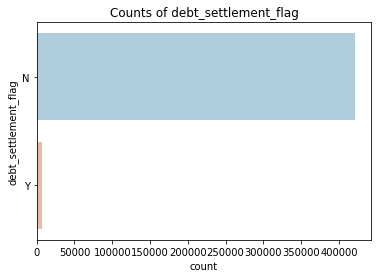

In [5]:
CategoricalList = ['term','grade','sub_grade','home_ownership','verification_status','purpose','addr_state','application_type','initial_list_status','debt_settlement_flag']

for i in range(0, len(CategoricalList)):
    countplotshorizontal(frame = df, field = CategoricalList[i], title = "Counts of " + CategoricalList[i], ylabel = CategoricalList[i], palette = "RdBu_r")

In [6]:
for i in range(0, len(CategoricalList)):
    Temp = df[CategoricalList[i]].value_counts() / len(df)
    df_Temp = pd.DataFrame(Temp)
    df_Temp.reset_index(level = 0, inplace = True)

    df = pd.merge(df, df_Temp, how = 'left', left_on = CategoricalList[i], right_on = 'index', suffixes = ('_1','_2'))
    
    if CategoricalList[i] == 'sub_grade':
        df[CategoricalList[i] + '_1'] = df[CategoricalList[i] + '_1']
    else:
        df[CategoricalList[i] + '_1'] = np.where(df[CategoricalList[i] + '_2'] < 0.050, 'Other', df[CategoricalList[i] + '_1'])
        
    df = df.drop(columns = [CategoricalList[i] + '_2', 'index'])
    df = df.rename(index = str, columns = {CategoricalList[i] + '_1': CategoricalList[i]})
    
display(HTML(df[0:5].to_html()))

,id,loan_amnt,funded_amnt,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,purpose,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag,count,YearMonth,YearQtr,fico_avg,fico_bin,GCL,NCL,replacement_d,time_in_file,term_int,loan_end_date,life_of_loan,life_of_loan_years,servicing_fee,total_rev,annual_rev,roa,term_E,grade_E,sub_grade_E,home_ownership_E,verification_status_E,purpose_E,addr_state_E,initial_list_status_E,debt_settlement_flag_E,OOT_Ind
0,10149566,8000,8000.000,36 months,10.990,261.880,B,B2,2,MORTGAGE,33000,Not Verified,2013-12-01,Charged Off,n,debt_consolidation,800xx,Other,15.750,0,1991-07-01,685,689,1,9,1,7203.000,34.600,16,f,5622.500,5622.500,3854.810,1120.220,15.000,632.470,113.720,2015-10-01,276.880,2016-10-01,524,520,0,1,Individual,0,0,15949,20800,2,1772,2255,72.500,0,0,129,269,14,14,0,18,6,0,3,5,4,7,2,8,14,5,9,0,0,0,0,100.000,75.000,1,0,33226,15949,8200,12426,N,Cash,N,1,201312,201304,687.000,682 to 697,-2362.500,-2881.250,2013-12-31,269.043,36,2016-11-30,21.979,1.832,56.225,-2547.445,-1390.814,-17.385,2.000,5.000,35.000,4.000,3.000,5.000,45.000,2.000,2.000,0
1,10148122,12000,12000.000,36 months,7.620,373.940,A,A3,3,MORTGAGE,96500,Not Verified,2013-12-01,Fully Paid,n,debt_consolidation,782xx,TX,12.610,0,2003-09-01,705,709,0,17,0,13248.000,55.700,30,f,13397.540,13397.540,12000.000,1397.540,0.000,0.000,0.000,2016-06-01,2927.220,2018-12-01,819,815,0,1,Individual,0,0,200314,23800,4,11783,2441,83.500,0,0,123,118,10,9,1,10,10,0,4,5,4,10,15,8,14,5,17,0,0,0,3,100.000,100.000,0,0,233004,46738,14800,53404,N,Cash,N,1,201312,201304,707.000,698 to 717,1397.540,1397.540,2013-12-31,123.006,36,2016-11-30,29.996,2.500,133.975,1263.565,505.495,4.212,2.000,4.000,33.000,4.000,3.000,5.000,32.000,2.000,2.000,0
2,10129506,20800,20800.000,36 months,13.530,706.160,B,B5,10,RENT,81500,Verified,2013-12-01,Fully Paid,n,debt_consolidation,100xx,NY,16.730,0,1998-06-01,685,689,2,29,0,23473.000,54.500,41,f,23926.640,23926.640,20800.000,3126.640,0.000,0.000,0.000,2015-05-01,13334.930,2018-12-01,654,650,0,1,Individual,0,0,23473,43100,9,869,6811,54.600,0,0,115,186,0,0,0,0,0,1,8,24,11,17,1,29,40,24,29,0,0,0,3,90.200,50.000,0,0,43100,23473,15000,0,N,Cash,N,1,201312,201304,687.000,682 to 697,3126.640,3126.640,2013-12-31,186.021,36,2016-11-30,16.953,1.413,239.266,2887.374,2043.824,9.826,2.000,5.000,26.000,1.000,2.000,5.000,9.000,2.000,2.000,0
3,10159611,10000,10000.000,36 months,9.670,321.130,B,B1,7,MORTGAGE,102000,Not Verified,2013-12-01,Fully Paid,n,debt_consolidation,027xx,Other,15.550,2,1989-10-01,670,674,0,9,0,9912.000,44.400,22,f,11560.462,11560.460,10000.000,1560.460,0.000,0.000,0.000,2017-01-01,320.910,2018-11-01,659,655,0,1,Individual,0,0,39143,22300,3,4349,973,89.400,0,0,243,290,23,8,0,25,8,1,3,4,3,6,9,6,13,4,9,0,0,0,1,77.300,66.700,0,0,58486,39143,9200,36186,N,Cash,N,1,201312,201304,672.000,<= 681,1560.462,1560.462,2013-12-31,2

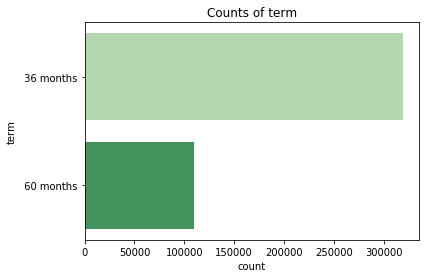

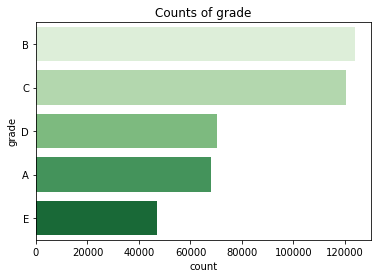

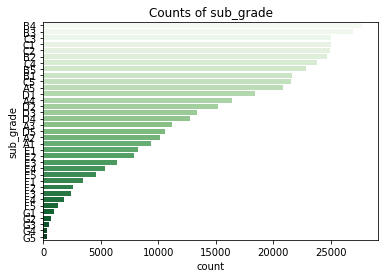

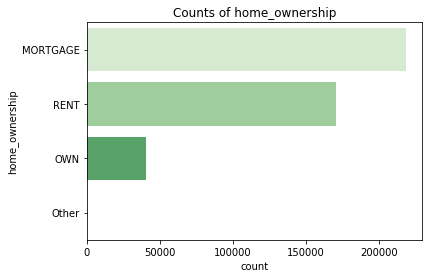

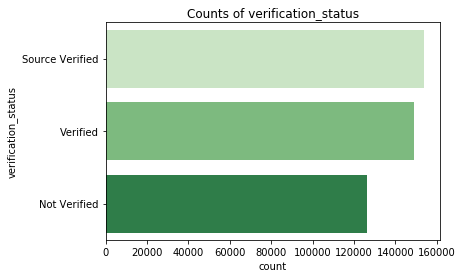

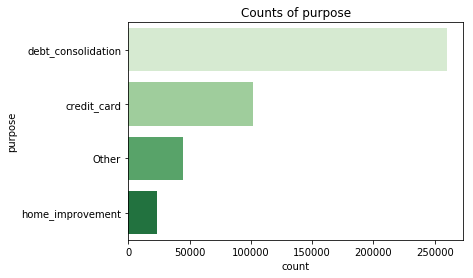

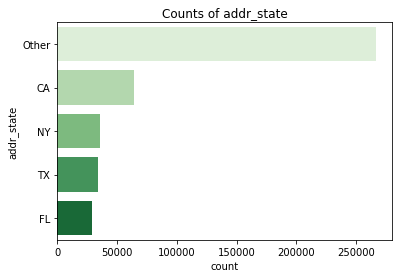

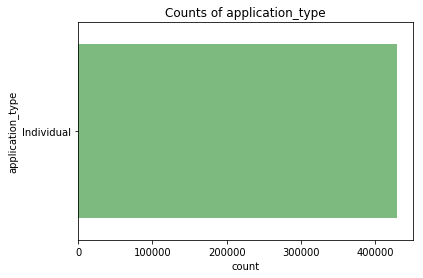

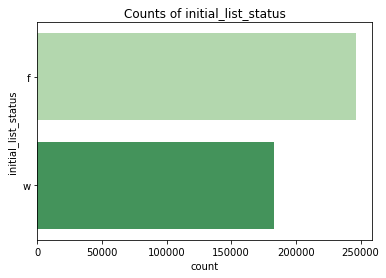

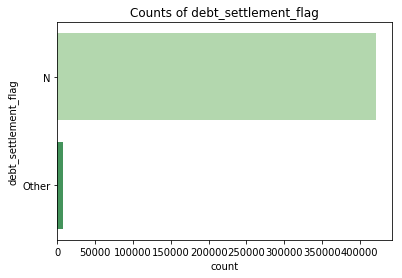

In [7]:
for i in range(0, len(CategoricalList)):
    countplotshorizontal(frame = df, field = CategoricalList[i], title = "Counts of " + CategoricalList[i], ylabel = CategoricalList[i], palette = "Greens")

### Remove Skewed Categories
* Some Categories are Skewed so Let's Make a List of Those Where the Largest Group is >= 95%
* Remove These Values From the Categorical List

In [8]:
Temp = df[CategoricalList[0]].value_counts() / len(df)
df_Temp = pd.DataFrame(Temp)
df_Temp.reset_index(level = 0, inplace = True)
df_Temp['measure'] = CategoricalList[0]
df_Temp = df_Temp.rename(index = str, columns = {CategoricalList[0]: 'percent', 'index': 'category'})

for i in range(1, len(CategoricalList)):
    Temp = df[CategoricalList[i]].value_counts() / len(df)
    df_Temp1 = pd.DataFrame(Temp)
    df_Temp1.reset_index(level = 0, inplace = True)
    df_Temp1['measure'] = CategoricalList[i]
    df_Temp1 = df_Temp1.rename(index = str, columns = {CategoricalList[i]: 'percent', 'index': 'category'})
    df_Temp = pd.concat([df_Temp, df_Temp1])

df_Temp = df_Temp[df_Temp['percent'] >= 0.95]

SkewList = df_Temp['measure'].tolist()

print(bold + 'Categorical List \n' + reset, CategoricalList, '\n')
print(bold + 'Skew List \n' + reset, SkewList, '\n')

for i in range(0, len(SkewList)):
    CategoricalList.remove(SkewList[i])
    
print(bold + 'New Categorical List \n' + reset, CategoricalList)

Categorical List 
 ['term', 'grade', 'sub_grade', 'home_ownership', 'verification_status', 'purpose', 'addr_state', 'application_type', 'initial_list_status', 'debt_settlement_flag'] 

Skew List 
 ['application_type', 'debt_settlement_flag'] 

New Categorical List 
 ['term', 'grade', 'sub_grade', 'home_ownership', 'verification_status', 'purpose', 'addr_state', 'initial_list_status']


In [9]:
for i in range(0, len(SkewList)):
    del df[SkewList[i]]

In [10]:
idList = ['id','issue_d','OOT_Ind']

ContinuousList = ['funded_amnt','int_rate','emp_length','annual_inc','dti','delinq_2yrs','inq_last_6mths','open_acc','pub_rec','revol_bal','revol_util','total_acc','time_in_file',
                  'collections_12_mths_ex_med','acc_now_delinq','tot_coll_amt','tot_cur_bal','total_rev_hi_lim','acc_open_past_24mths','avg_cur_bal','bc_open_to_buy','bc_util',
                  'chargeoff_within_12_mths','delinq_amnt','mo_sin_old_il_acct','mo_sin_old_rev_tl_op','mo_sin_rcnt_rev_tl_op','mo_sin_rcnt_tl','mort_acc','mths_since_recent_bc',
                  'mths_since_recent_inq','num_accts_ever_120_pd','num_actv_bc_tl','num_actv_rev_tl','num_bc_sats','num_bc_tl','num_il_tl','num_op_rev_tl','num_rev_accts',
                  'num_rev_tl_bal_gt_0','num_sats','num_tl_120dpd_2m','num_tl_30dpd','num_tl_90g_dpd_24m','num_tl_op_past_12m','pct_tl_nvr_dlq','percent_bc_gt_75','pub_rec_bankruptcies',
                  'tax_liens','tot_hi_cred_lim','total_bal_ex_mort','total_bc_limit','total_il_high_credit_limit','fico_avg','roa']

TotalList = idList + ContinuousList + CategoricalList
df = df[TotalList].copy(deep = True)

display(HTML(df[0:5].to_html()))

,id,issue_d,OOT_Ind,funded_amnt,int_rate,emp_length,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,time_in_file,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,fico_avg,roa,term,grade,sub_grade,home_ownership,verification_status,purpose,addr_state,initial_list_status
0,10149566,2013-12-01,0,8000.000,10.990,2,33000,15.750,0,1,9,1,7203.000,34.600,16,269.043,0,0,0,15949,20800,2,1772,2255,72.500,0,0,129,269,14,14,0,18,6,0,3,5,4,7,2,8,14,5,9,0,0,0,0,100.000,75.000,1,0,33226,15949,8200,12426,687.000,-17.385,36 months,B,B2,MORTGAGE,Not Verified,debt_consolidation,Other,f
1,10148122,2013-12-01,0,12000.000,7.620,3,96500,12.610,0,0,17,0,13248.000,55.700,30,123.006,0,0,0,200314,23800,4,11783,2441,83.500,0,0,123,118,10,9,1,10,10,0,4,5,4,10,15,8,14,5,17,0,0,0,3,100.000,100.000,0,0,233004,46738,14800,53404,707.000,4.212,36 months,A,A3,MORTGAGE,Not Verified,debt_consolidation,TX,f
2,10129506,2013-12-01,0,20800.000,13.530,10,81500,16.730,0,2,29,0,23473.000,54.500,41,186.021,0,0,0,23473,43100,9,869,6811,54.600,0,0,115,186,0,0,0,0,0,1,8,24,11,17,1,29,40,24,29,0,0,0,3,90.200,50.000,0,0,43100,23473,15000,0,687.000,9.826,36 months,B,B5,RENT,Verified,debt_consolidation,NY,f
3,10159611,2013-12-01,0,10000.000,9.670,7,102000,15.550,2,0,9,0,9912.000,44.400,22,290.004,0,0,0,39143,22300,3,4349,973,89.400,0,0,243,290,23,8,0,25,8,1,3,4,3,6,9,6,13,4,9,0,0,0,1,77.300,66.700,0,0,58486,39143,9200,36186,672.000,4.683,36 months,B,B1,MORTGAGE,Not Verified,debt_consolidation,Other,f
4,10127816,2013-12-01,0,24000.000,13.530,10,100000,22.180,0,0,14,0,21617.000,76.700,39,298.973,0,0,539,199834,28200,7,15372,4822,77.600,0,0,179,299,18,7,3,18,7,0,3,5,5,10,17,8,19,5,14,0,0,0,2,100.000,75.000,0,0,229072,61397,21500,58847,662.000,9.101,36 months,B,B5,MORTGAGE,Verified,credit_card,Other,w


### One Hot Encode the Categorical Variables
* Performing XGBoost Requires the Categorical Variables to be One Hot Encoded

In [11]:
for i in range(0, len(CategoricalList)):
    df = pd.concat([df.drop(CategoricalList[i], axis=1), pd.get_dummies(df[CategoricalList[i]], prefix = CategoricalList[i])], axis=1)
    
display(HTML(df[0:5].to_html()))

,id,issue_d,OOT_Ind,funded_amnt,int_rate,emp_length,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,time_in_file,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,fico_avg,roa,term_ 36 months,term_ 60 months,grade_A,grade_B,grade_C,grade_D,grade_E,sub_grade_A1,sub_grade_A2,sub_grade_A3,sub_grade_A4,sub_grade_A5,sub_grade_B1,sub_grade_B2,sub_grade_B3,sub_grade_B4,sub_grade_B5,sub_grade_C1,sub_grade_C2,sub_grade_C3,sub_grade_C4,sub_grade_C5,sub_grade_D1,sub_grade_D2,sub_grade_D3,sub_grade_D4,sub_grade_D5,sub_grade_E1,sub_grade_E2,sub_grade_E3,sub_grade_E4,sub_grade_E5,sub_grade_F1,sub_grade_F2,sub_grade_F3,sub_grade_F4,sub_grade_F5,sub_grade_G1,sub_grade_G2,sub_grade_G3,sub_grade_G4,sub_grade_G5,home_ownership_MORTGAGE,home_ownership_OWN,home_ownership_Other,home_ownership_RENT,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,purpose_Other,purpose_credit_card,purpose_debt_consolidation,purpose_home_improvement,addr_state_CA,addr_state_FL,addr_state_NY,addr_state_Other,addr_state_TX,initial_list_status_f,initial_list_status_w
0,10149566,2013-12-01,0,8000.000,10.990,2,33000,15.750,0,1,9,1,7203.000,34.600,16,269.043,0,0,0,15949,20800,2,1772,2255,72.500,0,0,129,269,14,14,0,18,6,0,3,5,4,7,2,8,14,5,9,0,0,0,0,100.000,75.000,1,0,33226,15949,8200,12426,687.000,-17.385,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0
1,10148122,2013-12-01,0,12000.000,7.620,3,96500,12.610,0,0,17,0,13248.000,55.700,30,123.006,0,0,0,200314,23800,4,11783,2441,83.500,0,0,123,118,10,9,1,10,10,0,4,5,4,10,15,8,14,5,17,0,0,0,3,100.000,100.000,0,0,233004,46738,14800,53404,707.000,4.212,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,1,0
2,10129506,2013-12-01,0,20800.000,13.530,10,81500,16.730,0,2,29,0,23473.000,54.500,41,186.021,0,0,0,23473,43100,9,869,6811,54.600,0,0,115,186,0,0,0,0,0,1,8,24,11,17,1,29,40,24,29,0,0,0,3,90.200,50.000,0,0,43100,23473,15000,0,687.000,9.826,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0
3,10159611,2013-12-01,0,10000.000,9.670,7,102000,15.550,2,0,9,0,9912.000,44.400,22,290.004,0,0,0,39143,22300,3,4349,973,89.400,0,0,243,290,23,8,0,25,8,1,3,4,3,6,9,6,13,4,9,0,0,0,1,77.300,66.700,0,0,58486,39143,9200,36186,672.000,4.683,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0
4,10127816,2013-12-01,0,24000.000,13.530,10,100000,22.180,0,0,14,0,21617.000,76.700,39,298.973,0,0,539,199834,28200,7,15372,4822,77.600,0,0,179,299,18,7,3,18,7,0,3,5,5,10,17,8,19,5,14,0,0,0,2,100.000,75.000,0,0,229072,61397,21500,58847,662.000,9.101,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1


In [12]:
### Continuous Variable Summary Statistics

pd.options.display.float_format = '{:,.2f}'.format
display(HTML(df.filter(ContinuousList, axis = 1).describe(percentiles = [.01,.05,.10,.25,.50,.75,.90,.95,.99]).to_html()))

,funded_amnt,int_rate,emp_length,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,time_in_file,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,fico_avg,roa
count,"429,387.00","429,387.00","429,387.00","429,387.00","429,387.00","429,387.00","429,387.00","429,387.00","429,387.00","429,387.00","429,166.00","429,387.00","429,387.00","429,387.00","429,387.00","429,387.00","429,387.00","429,387.00","429,387.00","429,387.00","429,387.00","425,035.00","429,387.00","429,387.00","429,387.00","429,387.00","429,387.00","429,387.00","429,387.00","429,387.00","429,387.00","429,387.00","429,387.00","429,387.00","429,387.00","429,387.00","429,387.00","429,387.00","429,387.00","429,387.00","429,387.00","429,387.00","429,387.00","429,387.00","429,387.00","429,235.00","425,172.00","429,387.00","429,387.00","429,387.00","429,387.00","429,387.00","429,387.00","429,387.00","429,387.00"
mean,"14,601.60",13.73,5.87,"74,105.76",17.88,0.31,0.74,11.51,0.20,"16,519.66",56.25,25.60,196.30,0.01,0.01,212.71,"137,814.76","30,617.62",4.31,"13,389.68","8,460.23",64.98,0.01,11.09,122.77,183.05,13.24,8.22,1.83,24.41,6.25,0.46,3.71,5.76,4.66,8.66,8.32,8.23,15.16,5.74,11.46,0.00,0.00,0.09,1.97,94.59,51.15,0.13,0.05,"167,714.06","46,961.77","20,235.23","38,319.98",695.17,0.76
std,"8,302.24",4.40,3.68,"54,662.14",8.02,0.85,1.02,5.13,0.57,"21,354.68",23.07,11.74,88.63,0.13,0.08,"14,090.71","151,878.48","37,349.96",2.86,"16,032.38","13,494.14",26.42,0.11,624.01,55.31,91.89,16.06,9.05,2.16,30.05,5.96,1.20,2.14,3.09,2.68,4.84,7.15,4.23,7.91,3.08,5.13,0.03,0.06,0.46,1.62,8.20,34.81,0.37,0.38,"170,119.67","44,788.15","20,013.23","40,270.63",29.19,19.89
min,"1,000.00",5.93,0.00,"3,000.00",0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00,36.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,3.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00,7.70,0.00,0.00,0.00,0.00,0.00,0.00,0.00,662.00,-100.00
1%,"2,000.00",6.03,0.00,"19,248.00",2.26,0.00,0.00,3.00,0.00,552.00,3.90,6.00,49.94,0.00,0.00,0.00,"3,558.00","3,000.00",0.00,521.00,0.00,0.40,0.00,0.00,0.00,36.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,1.00,0.00,2.00,3.00,1.00,3.00,0.00,0.00,0.00,0.00,64.00,0.00,0.00,0.00,"8,200.00","2,940.00",300.00,0.00,662.00,-79.78
5%,"3,750.00",6.92,0.00,"28,000.00",5.35,0.00,0.00,5.00,0.00,"2,357.00",16.40,9.00,79.97,0.00,0.00,0.00,"8,690.00","5,900.00",1.00,"1,110.00",73.00,15.00,0.00,0.00,16.00,65.00,1.00,1.00,0.00,2.00,0.00,0.00,1.00,2.00,1.00,3.00,1.00,3.00,5.00,2.00,5.00,0.00,0.00,0.00,0.00,77.30,0.00,0.00,0.00,"17,500.00","7,063.00","2,200.00",0.00,662.00,-54.46
10%,"5,000.00",7.90,1.00,"34,200.00",7.52,0.00,0.00,6.00,0.00,"3,665.00",24.80,12.00,98.92,0.00,0.00,0.00,"13,805.60","8,156.00",1.00,"1,620.00",249.00,25.90,0.00,0.00,45.00,84.00,2.00,2.00,0.00,3.00,0.00,0.00,1.00,2.00,2.00,3.00,2.00,4.00,6.00,2.00,6.00,0.00,0.00,0.00,0.00,83.30,0.00,0.00,0.00,"25,795.60","10,823.00","3,700.00",0.00,667.00,-20.53
25%,"8,000.00",10.64,2.00,"45,000.00",11.85,0.00,0.00,8.00,0.00,"6,558.00",39.60,17.00,136.05,0.00,0.00,0.00,"28,507.00","13,500.00",2.00,"3,047.00","1,067.00",46.30,0.00,0.00,93.00,118.00,4.00,3.00,0.00,6.00,1.00,0.00,2.00,4.00,3.00,5.00,3.00,5.00,9.00,4.00,8.00,0.00,0.00,0.00,1.00,92.00,25.00,0.00,0.00,"46,482.00","20,208.00","7,300.00","12,500.00",672.00,3.69
50%,"12,725.00",13.35,6.00,"64,0

### Convert Some of the Continuous to Binary

In [13]:
BinaryList = ['pub_rec','num_accts_ever_120_pd','pub_rec_bankruptcies','num_tl_90g_dpd_24m']

for i in range(0, len(BinaryList)):
    df[BinaryList[i]] = np.where(df[BinaryList[i]] > 1, 1, df[BinaryList[i]])

### Remove Continuous Outliers & Fill in Missings with 0.

In [14]:
df['annual_inc'] = np.where(df['annual_inc'] > 250000, 250000, df['annual_inc'])
df['revol_bal'] = np.where(df['revol_bal'] > 100000, 100000, np.where(df['revol_bal'] is np.nan, 0, df['revol_bal']))
df['bc_util'] = np.where(df['bc_util'] > 100, 100, np.where(df['bc_util'] is np.nan, 0, df['bc_util']))
df['revol_util'] = np.where(df['revol_util'] > 100, 100, np.where(df['revol_util'] is np.nan, 0, df['revol_util']))
df['percent_bc_gt_75'] = np.where(df['percent_bc_gt_75'] is np.nan, 0, df['percent_bc_gt_75'])
df['time_in_file'] = np.where(df['time_in_file'] > 500, 500, df['time_in_file'])
df['total_acc'] = np.where(df['total_acc'] > 60, 60, df['total_acc'])
df['tot_coll_amt'] = np.where(df['tot_coll_amt'] > 5000, 5000, df['tot_coll_amt'])
df['tot_cur_bal'] = np.where(df['tot_cur_bal'] > 500000, 500000, df['tot_cur_bal'])
df['total_rev_hi_lim'] = np.where(df['total_rev_hi_lim'] > 150000, 150000, df['total_rev_hi_lim'])
df['acc_open_past_24mths'] = np.where(df['acc_open_past_24mths'] > 15, 15, df['acc_open_past_24mths'])
df['avg_cur_bal'] = np.where(df['avg_cur_bal'] > 75000, 75000, df['avg_cur_bal'])
df['mo_sin_old_rev_tl_op'] = np.where(df['mo_sin_old_rev_tl_op'] > 500, 500, df['mo_sin_old_rev_tl_op'])
df['mo_sin_rcnt_tl'] = np.where(df['mo_sin_rcnt_tl'] > 50, 50, df['mo_sin_rcnt_tl'])
df['mths_since_recent_bc'] = np.where(df['mths_since_recent_bc'] > 150, 150, df['mths_since_recent_bc'])
df['pub_rec_bankruptcies'] = np.where(df['pub_rec_bankruptcies'] > 1, 1, df['pub_rec_bankruptcies'])
df['tot_hi_cred_lim'] = np.where(df['tot_hi_cred_lim'] > 750000, 750000, df['tot_hi_cred_lim'])
df['total_bal_ex_mort'] = np.where(df['total_bal_ex_mort'] > 250000, 250000, df['total_bal_ex_mort'])
df['total_bc_limit'] = np.where(df['total_bc_limit'] > 100000, 100000, df['total_bc_limit'])
df['total_il_high_credit_limit'] = np.where(df['total_il_high_credit_limit'] > 200000, 200000, df['total_il_high_credit_limit'])
df['bc_open_to_buy'] = np.where(df['bc_open_to_buy'] > 70000, 70000, df['bc_open_to_buy'])
df['mo_sin_old_il_acct'] = np.where(df['mo_sin_old_il_acct'] > 270, 270, df['mo_sin_old_il_acct'])
df['mo_sin_rcnt_rev_tl_op'] = np.where(df['mo_sin_rcnt_rev_tl_op'] > 80, 80, df['mo_sin_rcnt_rev_tl_op'])
df['mort_acc'] = np.where(df['mort_acc'] > 10, 10, df['mort_acc'])
df['num_actv_bc_tl'] = np.where(df['num_actv_bc_tl'] > 11, 11, df['num_actv_bc_tl'])
df['num_actv_rev_tl'] = np.where(df['num_actv_rev_tl'] > 16, 16, df['num_actv_rev_tl'])
df['num_bc_sats'] = np.where(df['num_bc_sats'] > 13, 13, df['num_bc_sats'])
df['num_bc_tl'] = np.where(df['num_bc_tl'] > 25, 25, df['num_bc_tl'])
df['num_il_tl'] = np.where(df['num_il_tl'] > 35, 35, df['num_il_tl'])
df['num_op_rev_tl'] = np.where(df['num_op_rev_tl'] > 22, 22, df['num_op_rev_tl'])
df['num_rev_accts'] = np.where(df['num_rev_accts'] > 40, 40, df['num_rev_accts'])
df['num_rev_tl_bal_gt_0'] = np.where(df['num_rev_tl_bal_gt_0'] > 16, 16, df['num_rev_tl_bal_gt_0'])
df['num_sats'] = np.where(df['num_sats'] > 27, 27, df['num_sats'])
df['num_tl_op_past_12m'] = np.where(df['num_tl_op_past_12m'] > 7, 7, df['num_tl_op_past_12m'])

In [15]:
### Continuous Variable Summary Statistics

pd.options.display.float_format = '{:,.2f}'.format
display(HTML(df.filter(ContinuousList, axis = 1).describe(percentiles = [.01,.05,.10,.25,.50,.75,.90,.95,.99]).to_html()))

,funded_amnt,int_rate,emp_length,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,time_in_file,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,fico_avg,roa
count,"429,387.00","429,387.00","429,387.00","429,387.00","429,387.00","429,387.00","429,387.00","429,387.00","429,387.00","429,387.00","429,166.00","429,387.00","429,387.00","429,387.00","429,387.00","429,387.00","429,387.00","429,387.00","429,387.00","429,387.00","429,387.00","425,035.00","429,387.00","429,387.00","429,387.00","429,387.00","429,387.00","429,387.00","429,387.00","429,387.00","429,387.00","429,387.00","429,387.00","429,387.00","429,387.00","429,387.00","429,387.00","429,387.00","429,387.00","429,387.00","429,387.00","429,387.00","429,387.00","429,387.00","429,387.00","429,235.00","425,172.00","429,387.00","429,387.00","429,387.00","429,387.00","429,387.00","429,387.00","429,387.00","429,387.00"
mean,"14,601.60",13.73,5.87,"72,985.66",17.88,0.31,0.74,11.51,0.16,"15,960.21",56.23,25.54,196.00,0.01,0.01,121.50,"133,067.26","29,919.53",4.30,"13,136.77","8,266.25",64.93,0.01,11.09,122.37,182.76,13.05,8.08,1.82,24.05,6.25,0.22,3.69,5.73,4.64,8.63,8.26,8.20,15.10,5.72,11.42,0.00,0.00,0.06,1.95,94.59,51.15,0.12,0.05,"165,353.04","46,398.27","20,005.08","37,781.11",695.17,0.76
std,"8,302.24",4.40,3.68,"40,396.49",8.02,0.85,1.02,5.13,0.37,"14,700.76",23.01,11.51,87.43,0.13,0.08,579.89,"131,085.46","24,952.82",2.80,"14,289.56","12,159.16",26.32,0.11,624.01,53.97,90.76,14.96,8.08,2.11,27.75,5.96,0.42,2.08,2.99,2.55,4.71,6.85,4.08,7.68,2.97,4.93,0.03,0.06,0.23,1.54,8.20,34.81,0.33,0.38,"154,750.61","40,254.41","18,656.53","36,944.87",29.19,19.89
min,"1,000.00",5.93,0.00,"3,000.00",0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00,36.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,3.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00,7.70,0.00,0.00,0.00,0.00,0.00,0.00,0.00,662.00,-100.00
1%,"2,000.00",6.03,0.00,"19,248.00",2.26,0.00,0.00,3.00,0.00,552.00,3.90,6.00,49.94,0.00,0.00,0.00,"3,558.00","3,000.00",0.00,521.00,0.00,0.40,0.00,0.00,0.00,36.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,1.00,0.00,2.00,3.00,1.00,3.00,0.00,0.00,0.00,0.00,64.00,0.00,0.00,0.00,"8,200.00","2,940.00",300.00,0.00,662.00,-79.78
5%,"3,750.00",6.92,0.00,"28,000.00",5.35,0.00,0.00,5.00,0.00,"2,357.00",16.40,9.00,79.97,0.00,0.00,0.00,"8,690.00","5,900.00",1.00,"1,110.00",73.00,15.00,0.00,0.00,16.00,65.00,1.00,1.00,0.00,2.00,0.00,0.00,1.00,2.00,1.00,3.00,1.00,3.00,5.00,2.00,5.00,0.00,0.00,0.00,0.00,77.30,0.00,0.00,0.00,"17,500.00","7,063.00","2,200.00",0.00,662.00,-54.46
10%,"5,000.00",7.90,1.00,"34,200.00",7.52,0.00,0.00,6.00,0.00,"3,665.00",24.80,12.00,98.92,0.00,0.00,0.00,"13,805.60","8,156.00",1.00,"1,620.00",249.00,25.90,0.00,0.00,45.00,84.00,2.00,2.00,0.00,3.00,0.00,0.00,1.00,2.00,2.00,3.00,2.00,4.00,6.00,2.00,6.00,0.00,0.00,0.00,0.00,83.30,0.00,0.00,0.00,"25,795.60","10,823.00","3,700.00",0.00,667.00,-20.53
25%,"8,000.00",10.64,2.00,"45,000.00",11.85,0.00,0.00,8.00,0.00,"6,558.00",39.60,17.00,136.05,0.00,0.00,0.00,"28,507.00","13,500.00",2.00,"3,047.00","1,067.00",46.30,0.00,0.00,93.00,118.00,4.00,3.00,0.00,6.00,1.00,0.00,2.00,4.00,3.00,5.00,3.00,5.00,9.00,4.00,8.00,0.00,0.00,0.00,1.00,92.00,25.00,0.00,0.00,"46,482.00","20,208.00","7,300.00","12,500.00",672.00,3.69
50%,"12,725.00",13.35,6.00,"64,000.00

In [16]:
RemoveList = ['collections_12_mths_ex_med','chargeoff_within_12_mths','acc_now_delinq','delinq_amnt','num_tl_120dpd_2m','num_tl_30dpd','tax_liens']

for i in range(0, len(RemoveList)):
    try:
        del df[RemoveList[i]]
    except:
        print('Variable ' + RemoveList[i] + ' not in DataFrame')
    try:
        ContinuousList.remove(RemoveList[i])
    except:
        print("Unexpected error:", sys.exc_info()[0])
        raise

C:\Users\apost\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


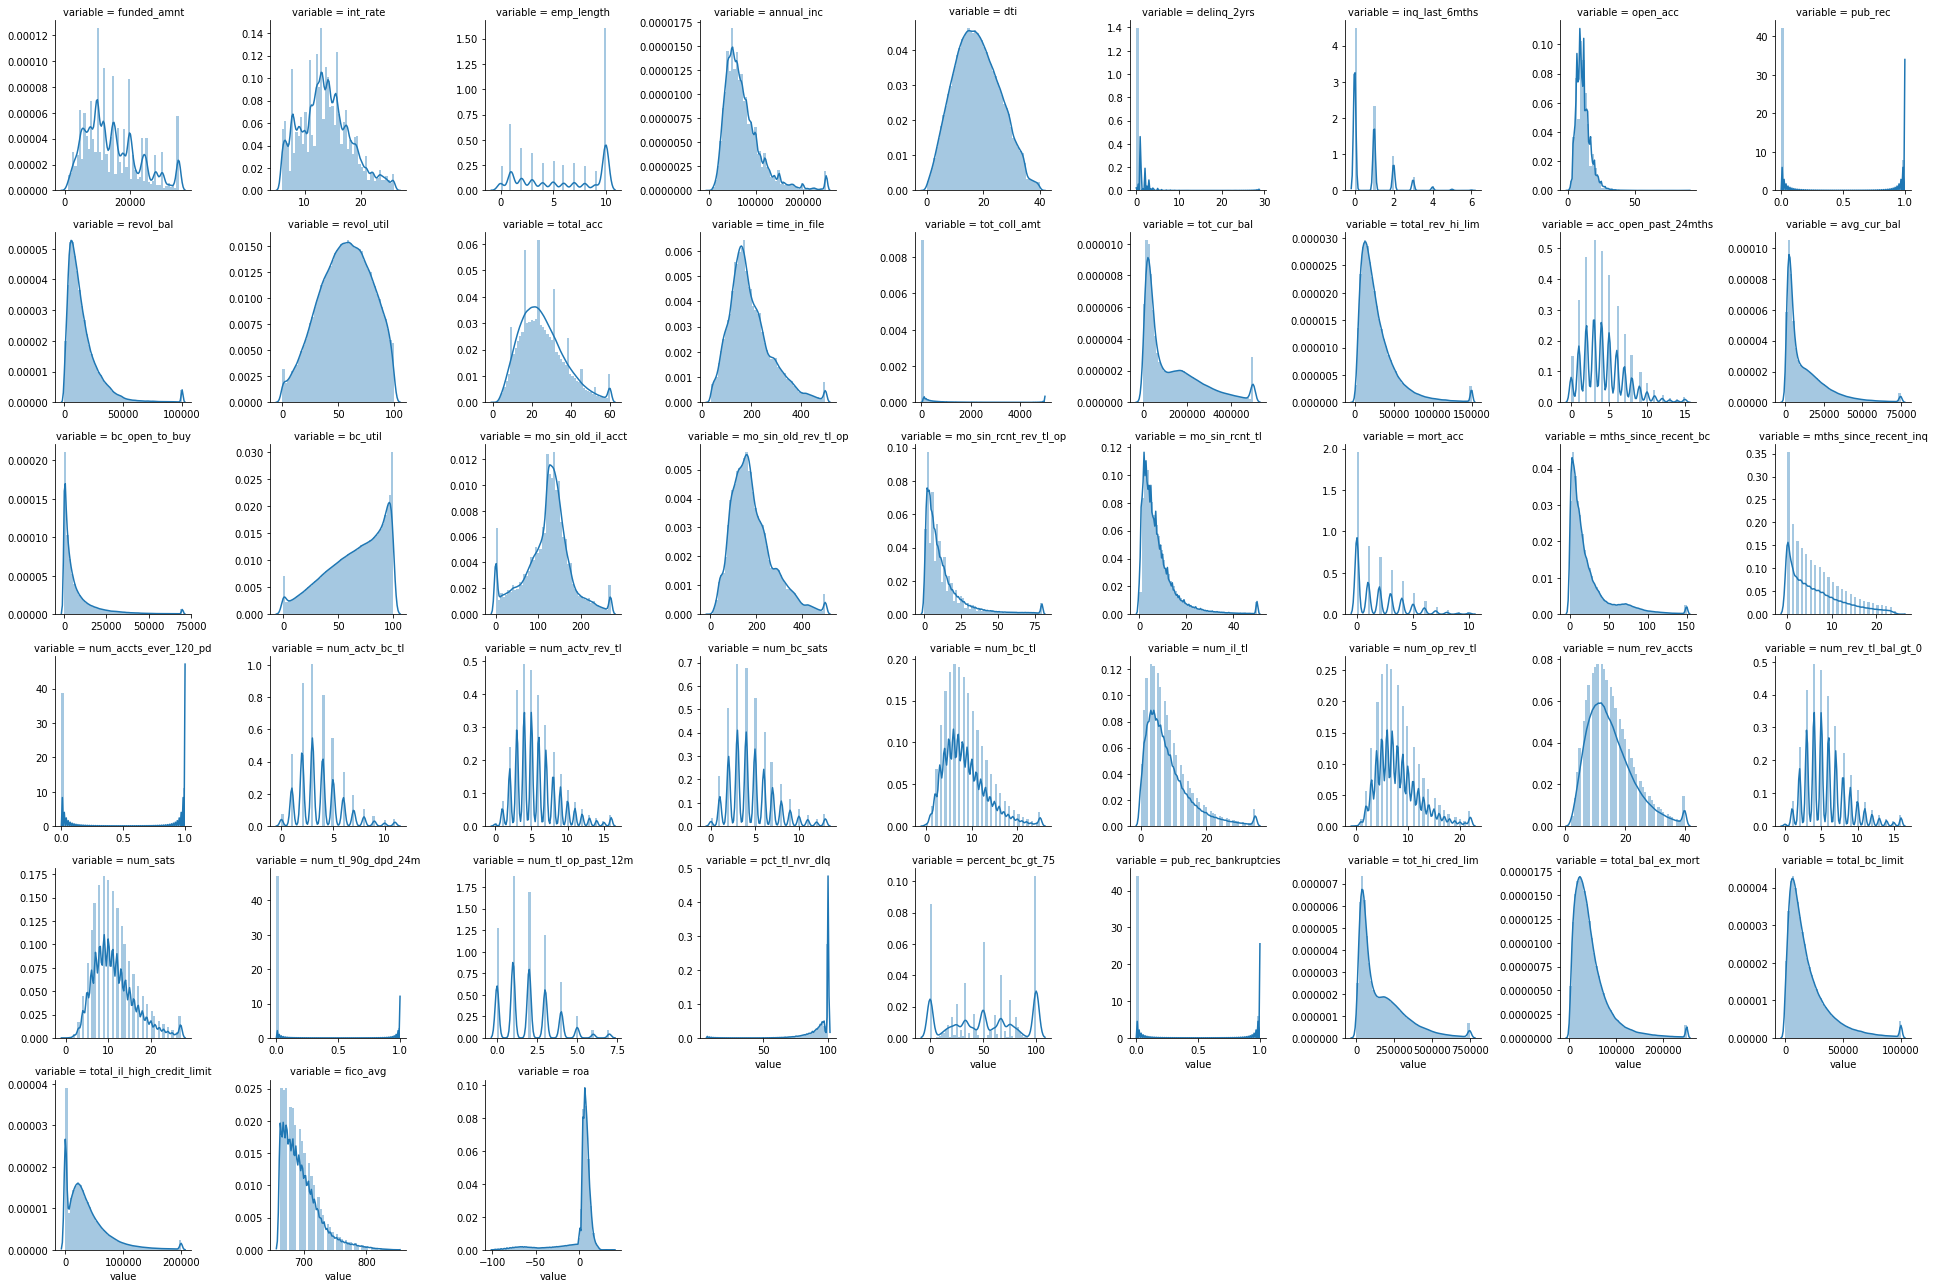

In [17]:
f = pd.melt(df, value_vars = ContinuousList)
g = sns.FacetGrid(f, col = "variable",  col_wrap = 9, sharex = False, sharey = False)
g = g.map(sns.distplot, "value")

### A few Continuous Variables have been noted as Log Transformation Candidates.
* Below we attemp the transformations

In [18]:
# QQ(frame = df, variable = 'int_rate', title = 'Interest Rate')
# # Applying Log Transformation
# df['int_rate'] = np.log(df['int_rate'])
# QQ(frame = df, variable = 'int_rate', title = 'Log Interest Rate')

In [19]:
# QQ(frame = df, variable = 'revol_bal', title = 'Open Revolving Balance')
# # Applying Log Transformation
# df['revol_bal'] = np.log(df['revol_bal'].astype(int))
# QQ(frame = df, variable = 'revol_bal', title = 'Log Revolving Balance')

C:\Users\apost\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval



 mu = 72985.66 and sigma = 40396.44



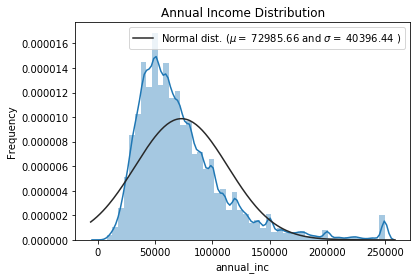

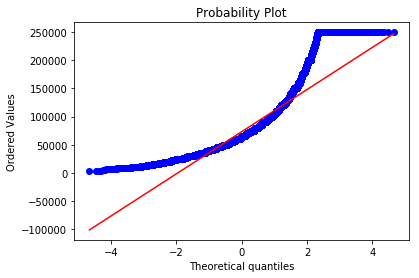


 mu = 11.07 and sigma = 0.51



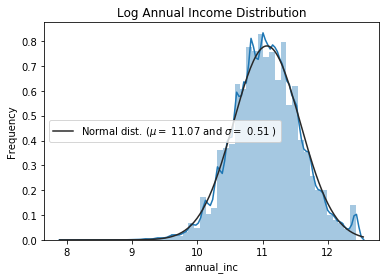

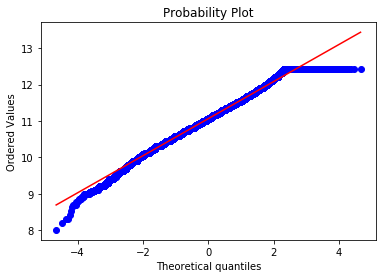

In [20]:
QQ(frame = df, variable = 'annual_inc', title = 'Annual Income')
# Applying Log Transformation
df['annual_inc'] = np.log(df['annual_inc'].astype(int))
QQ(frame = df, variable = 'annual_inc', title = 'Log Annual Income')

C:\Users\apost\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval



 mu = 196.00 and sigma = 87.43



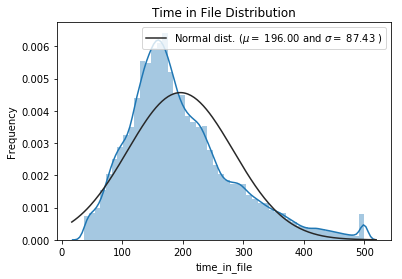

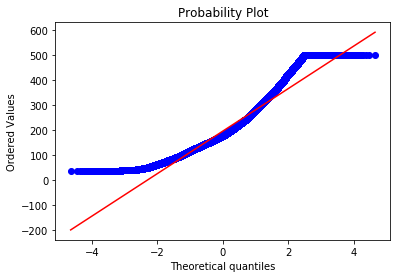


 mu = 5.18 and sigma = 0.46



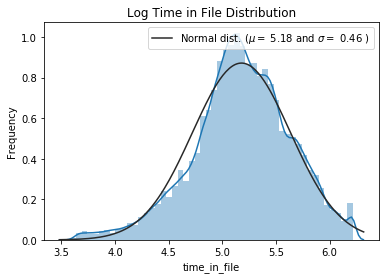

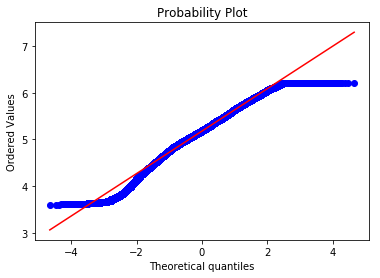

In [21]:
QQ(frame = df, variable = 'time_in_file', title = 'Time in File')
# Applying Log Transformation
df['time_in_file'] = np.log(df['time_in_file'])
QQ(frame = df, variable = 'time_in_file', title = 'Log Time in File')

In [22]:
# QQ(frame = df, variable = 'fico_avg', title = 'Avg FICO')
# # Applying Log Transformation
# df['fico_avg'] = np.log(df['fico_avg'])
# QQ(frame = df, variable = 'fico_avg', title = 'Log Avg FICO')

### Check Continuous for Skewness and Transform
* Anywhere Significant Skew is Found, Perform a Variable Transformation Using Box Cox or Log
* Threshold for the Initial Model was Chosen as 1.00.  However, Tighter Limits can be Chosen.

In [23]:
# Check the skew of all numerical features

ContinuousList.remove('roa')

skewed_feats = df[ContinuousList].apply(lambda x: skew(x.dropna())).sort_values(ascending = False)

skewness = pd.DataFrame({'Skew' :skewed_feats})

skewness = skewness[abs(skewness) > 1.00]
# skewness = skewness[abs(skewness) > 0.75]
skewness = skewness.dropna(how = 'all')
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

print(skewness)

There are 25 skewed numerical features to Box Cox transform
                            Skew
tot_coll_amt                6.75
delinq_2yrs                 5.28
num_tl_90g_dpd_24m          3.81
bc_open_to_buy              2.72
revol_bal                   2.63
mo_sin_rcnt_tl              2.52
mo_sin_rcnt_rev_tl_op       2.42
pub_rec_bankruptcies        2.33
total_bal_ex_mort           2.23
total_rev_hi_lim            2.16
mths_since_recent_bc        2.12
avg_cur_bal                 1.90
total_bc_limit              1.88
pub_rec                     1.85
total_il_high_credit_limit  1.80
inq_last_6mths              1.64
num_il_tl                   1.52
tot_hi_cred_lim             1.44
fico_avg                    1.39
num_accts_ever_120_pd       1.33
mort_acc                    1.27
open_acc                    1.23
tot_cur_bal                 1.16
num_rev_tl_bal_gt_0         1.00
pct_tl_nvr_dlq             -2.17


### Some of These Intuitively Shouldn't be Transformed, Like the Ones with a Lot of zeros.
* Make a Do Not Transform List for Those

In [24]:
NoTransformList = ['int_rate','annual_inc','fico_avg','time_in_file',
                   'tot_coll_amt','delinq_2yrs','bc_open_to_buy','pub_rec_bankruptcies','mths_since_recent_bc','num_il_tl','pub_rec',
                   'inq_last_6mths','mort_acc','pct_tl_nvr_dlq','num_accts_ever_120_pd','acc_now_delinq','collections_12_mths_ex_med']

C:\Users\apost\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


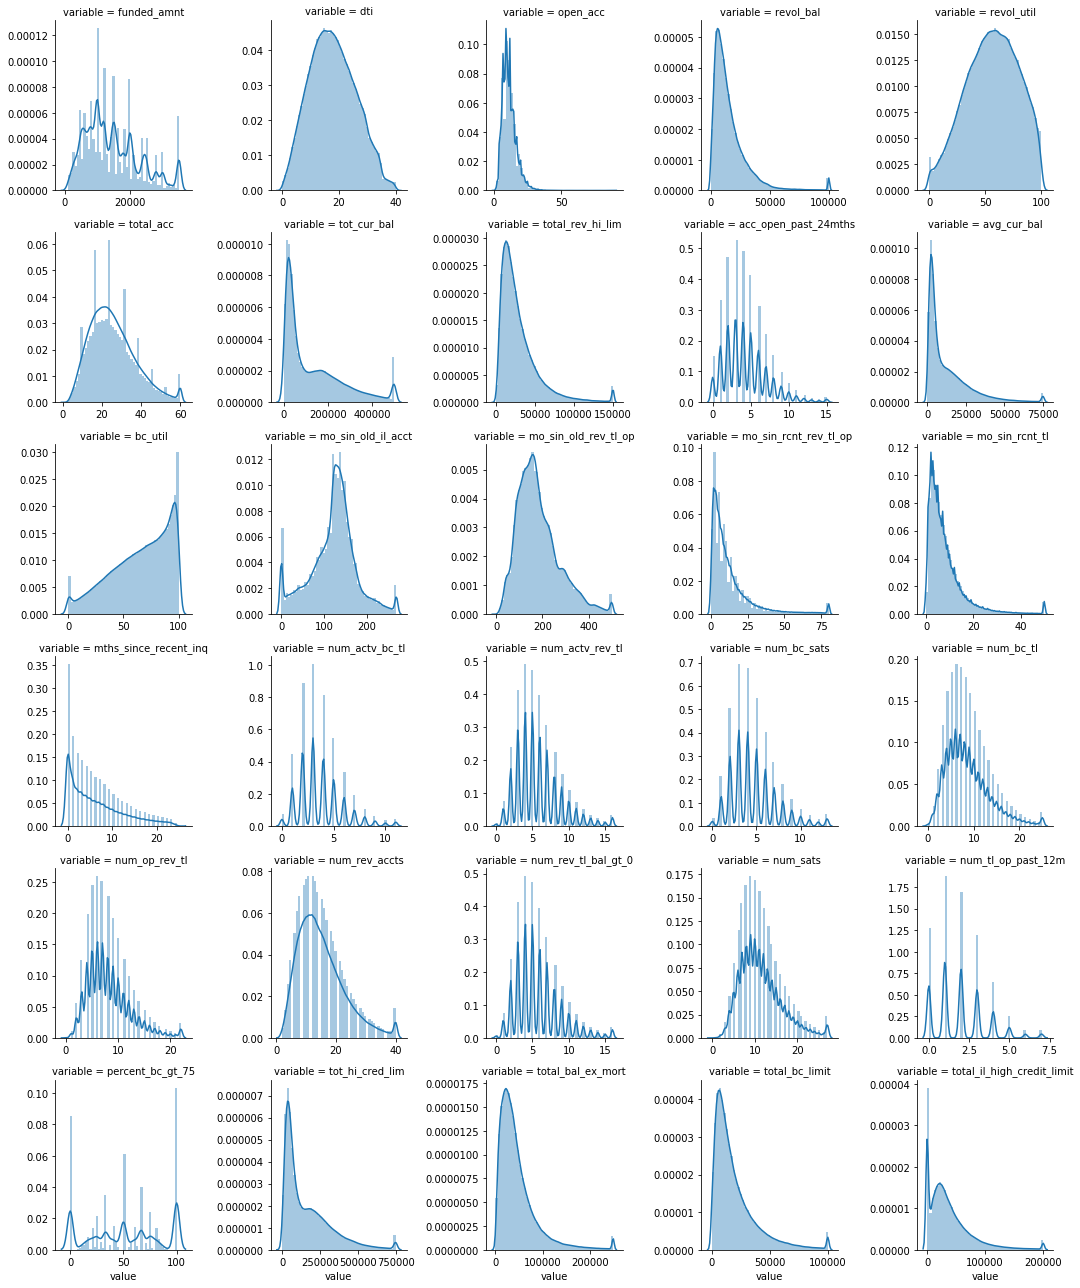

In [25]:
### First, Display the ones that Will Transform
TxList = ['funded_amnt','dti','open_acc','revol_bal','revol_util','total_acc','tot_cur_bal','total_rev_hi_lim','acc_open_past_24mths','avg_cur_bal','bc_util','mo_sin_old_il_acct',
          'mo_sin_old_rev_tl_op','mo_sin_rcnt_rev_tl_op','mo_sin_rcnt_tl','mths_since_recent_inq','num_actv_bc_tl','num_actv_rev_tl','num_bc_sats','num_bc_tl','num_op_rev_tl',
          'num_rev_accts','num_rev_tl_bal_gt_0','num_sats','num_tl_op_past_12m','percent_bc_gt_75','tot_hi_cred_lim','total_bal_ex_mort','total_bc_limit','total_il_high_credit_limit']

f = pd.melt(df, value_vars = TxList)
g = sns.FacetGrid(f, col = "variable",  col_wrap = 5, sharex = False, sharey = False)
g = g.map(sns.distplot, "value")

In [26]:
skewed_features = skewness.index

lam = 0.15
for feat in skewed_features:
    if feat in NoTransformList:
        df[feat] = df[feat]
    else:
        df[feat] = boxcox1p(df[feat], lam)

In [27]:
RemoveList = ['int_rate','annual_inc','fico_avg','time_in_file',
              'tot_coll_amt','pub_rec','num_accts_ever_120_pd','num_tl_90g_dpd_24m','pct_tl_nvr_dlq','pub_rec_bankruptcies','delinq_2yrs','bc_open_to_buy','emp_length',
              'mths_since_recent_bc','num_il_tl','inq_last_6mths','mort_acc','pct_tl_nvr_dlq','num_accts_ever_120_pd','acc_now_delinq','collections_12_mths_ex_med']

for i in range(0, len(RemoveList)):
    try:
        ContinuousList.remove(RemoveList[i])
    except:
        print('Variable ' + RemoveList[i] + ' Not in List')

Variable pct_tl_nvr_dlq Not in List
Variable num_accts_ever_120_pd Not in List
Variable acc_now_delinq Not in List
Variable collections_12_mths_ex_med Not in List


C:\Users\apost\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


['funded_amnt', 'dti', 'open_acc', 'revol_bal', 'revol_util', 'total_acc', 'tot_cur_bal', 'total_rev_hi_lim', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_util', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mths_since_recent_inq', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_op_past_12m', 'percent_bc_gt_75', 'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit', 'total_il_high_credit_limit', 'roa']


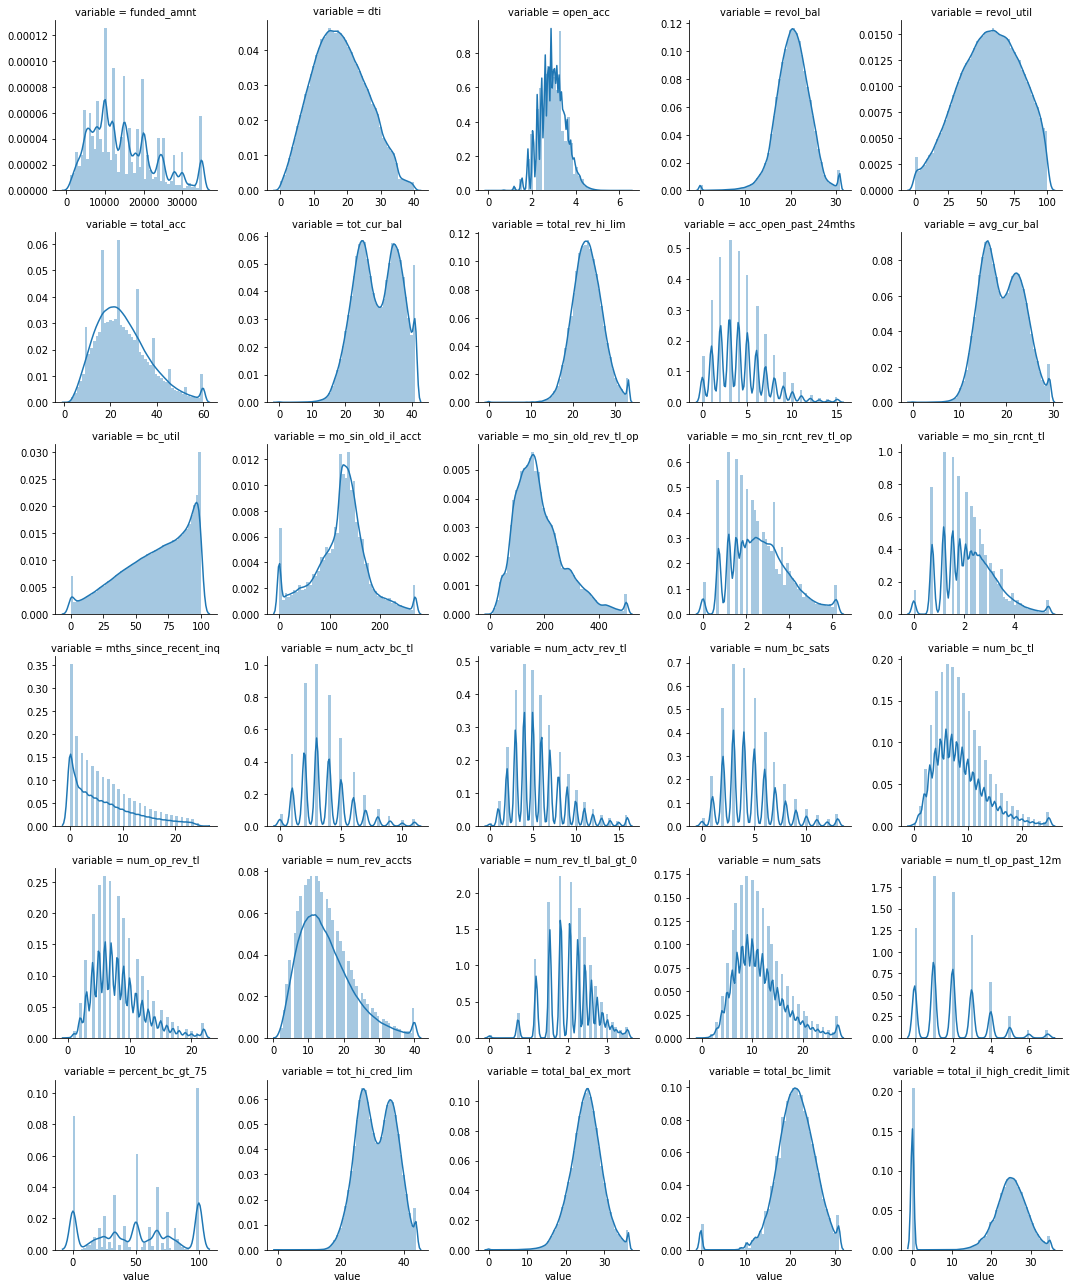

In [28]:
f = pd.melt(df, value_vars = ContinuousList)
g = sns.FacetGrid(f, col = "variable",  col_wrap = 5, sharex = False, sharey = False)
g = g.map(sns.distplot, "value")

ContinuousList.extend(['roa'])
print(ContinuousList)

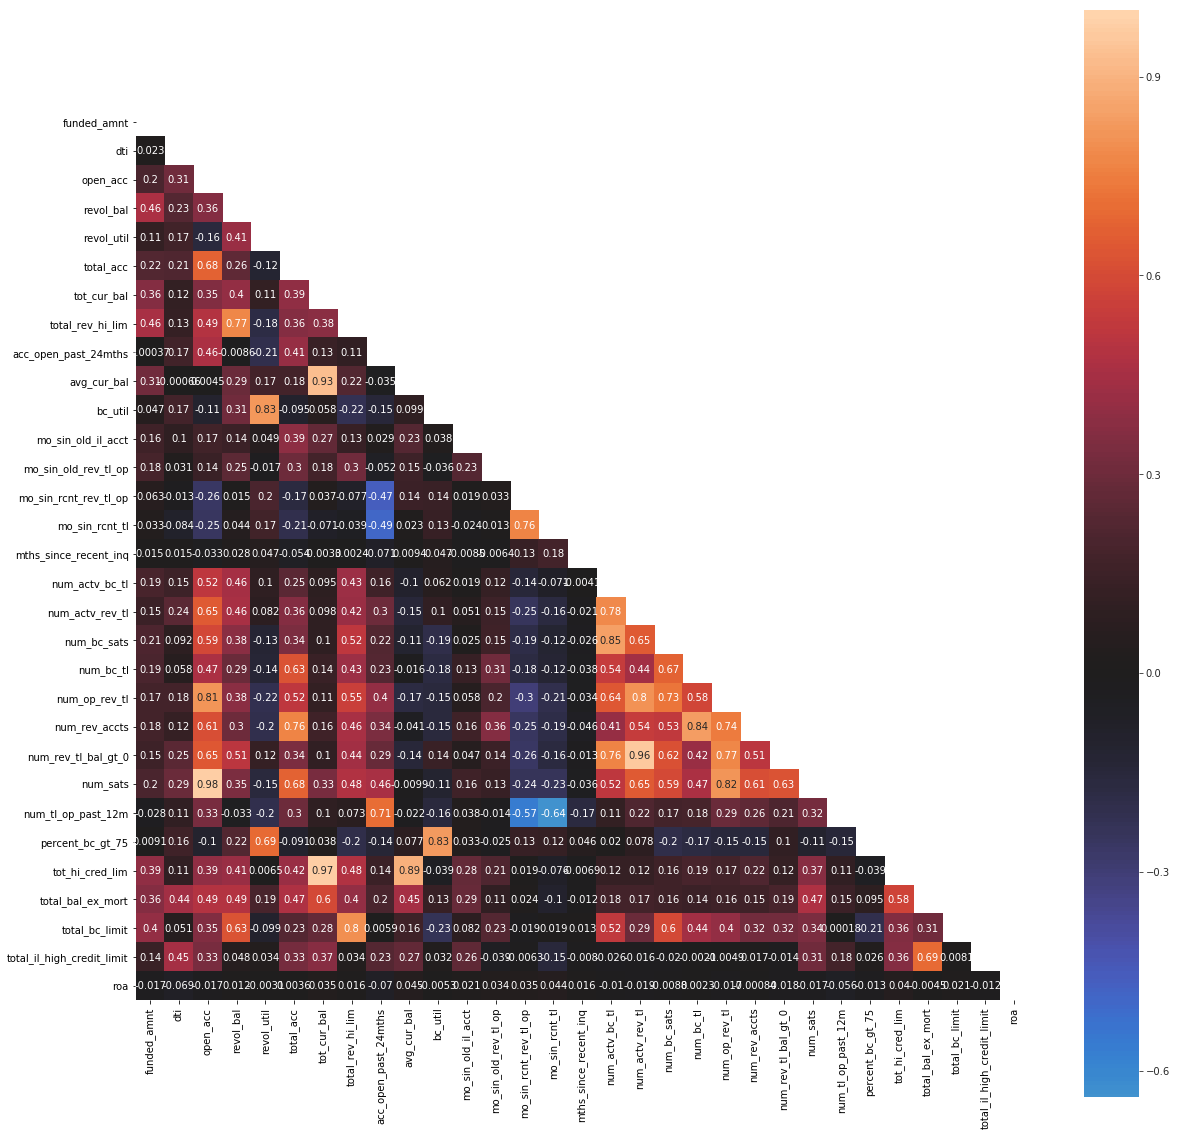

In [29]:
dfCorr = df[ContinuousList].copy(deep = True)

corr = dfCorr.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(20, 20))
with sns.axes_style("white"):
    ax = sns.heatmap(corr, mask = mask, vmax = 1, center = 0, square = True, annot = True)

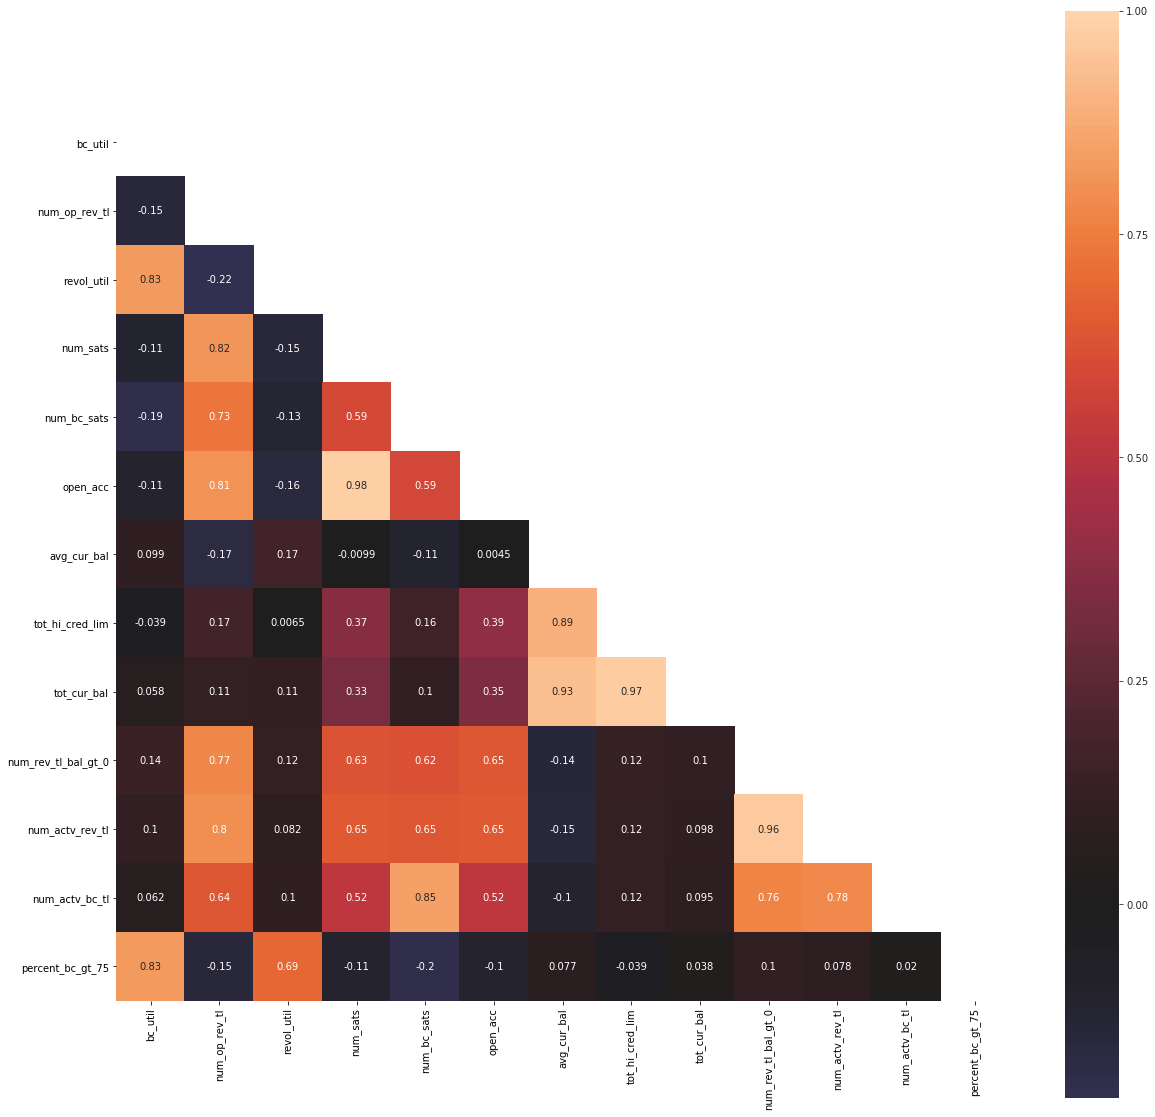

In [30]:
dfCorr = df[['bc_util','num_op_rev_tl','revol_util','num_sats','num_bc_sats','open_acc','avg_cur_bal','tot_hi_cred_lim','tot_cur_bal','num_rev_tl_bal_gt_0',
             'num_actv_rev_tl','num_actv_bc_tl','percent_bc_gt_75']].copy(deep = True)

corr = dfCorr.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(20, 20))
with sns.axes_style("white"):
    ax = sns.heatmap(corr, mask = mask, vmax = 1, center = 0, square = True, annot = True)

In [31]:
CorrRemoveList = ['num_bc_sats','num_sats','num_op_rev_tl','bc_util','num_rev_tl_bal_gt_0','tot_hi_cred_lim','avg_cur_bal']

for i in range(0, len(CorrRemoveList)):
    del df[CorrRemoveList[i]]

In [32]:
# Before we Save the DataFrame, strip the blank spaces from column names and replace with "_".
df.columns = df.columns.str.replace(' ', '_')

In [33]:
# Save the DataFrame
df.to_pickle('df3.pkl')

In [34]:
end_time = time.time()

diff = end_time - begin_time

print("run time ...", "\n")
print(diff, "seconds")
print(diff / 60, "minutes")
print(diff / 3600, "hours")

run time ... 

219.37299990653992 seconds
3.6562166651089987 minutes
0.06093694441848331 hours
